In [4]:
from   import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from numpy import array

#newral networks
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten


#Arima/autoarima
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

#Config
plt.rcParams["figure.figsize"] = (20,3)

import random
random.seed(1)

SyntaxError: invalid syntax (2964226211.py, line 1)

In [ ]:
pip install tensorflow

In [3]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


Creamos un modelo basico, sin periodos y en la que los valores se incrementan de manera aleatoria con un poco de ruido.

<AxesSubplot:title={'center':'Datos Artificiales'}>

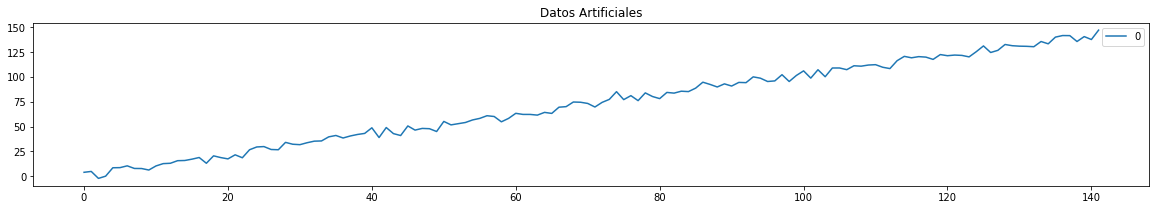

In [4]:
# build testDataset
def buildDataset(size):
    data = []
    noise = np.random.normal(0,1,size)
    for i in range(2, size):
        data.append((i + 3*noise[i]))
    return data
buildedData = pd.DataFrame(data=buildDataset(144))
buildedData.plot(title='Datos Artificiales')

Se lee nuestro dataset

In [5]:
archivo = r"C:\Users\jgutierrez\Downloads\Venta MIC 12092022.xlsx"

rawDF = pd.read_excel(archivo, sheet_name="Hoja2",header=0)

In [6]:
rawDF.head(5)

,anio,mes,dia,dtoprom,tiendas,unidades,venta,vtaprom
0,2018,1,1,29.881639,151,159308,4.053637e+09,2.684528e+07
1,2018,2,1,31.211792,150,187561,4.627658e+09,3.085105e+07
2,2018,3,1,25.790836,150,229235,5.902928e+09,3.935285e+07
3,2018,4,1,24.031031,153,240377,6.141973e+09,4.014361e+07
4,2018,5,1,28.891854,160,220514,5.968165e+09,3.730103e+07


In [7]:
rawDF['fecha'] = pd.to_datetime({'year':rawDF.anio, 'month': rawDF.mes, 'day': rawDF.dia})
rawDF.head()

,anio,mes,dia,dtoprom,tiendas,unidades,venta,vtaprom,fecha
0,2018,1,1,29.881639,151,159308,4.053637e+09,2.684528e+07,2018-01-01
1,2018,2,1,31.211792,150,187561,4.627658e+09,3.085105e+07,2018-02-01
2,2018,3,1,25.790836,150,229235,5.902928e+09,3.935285e+07,2018-03-01
3,2018,4,1,24.031031,153,240377,6.141973e+09,4.014361e+07,2018-04-01
4,2018,5,1,28.891854,160,220514,5.968165e+09,3.730103e+07,2018-05-01


Graficar el dataset

(56,)


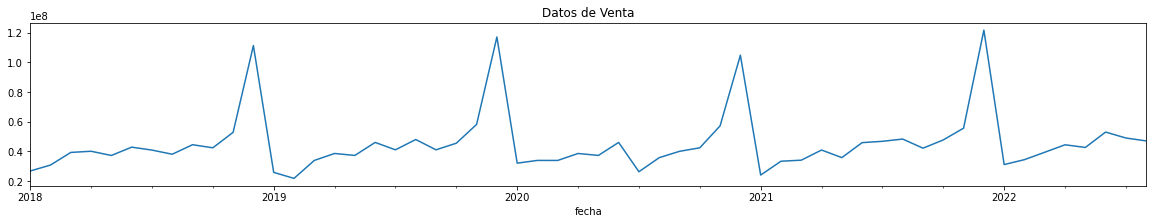

In [8]:
df = rawDF['vtaprom']
df.index = rawDF['fecha']
realData = df
# ver datos
df.plot(title='Datos de Venta')
print(df.shape)

Separar datos entre test y entrenamiento

In [9]:
#Datos reales
data = realData
SIZE = data.shape[0]
TRAIN_SPLIT = round(SIZE * 0.85)

#Estandarizar
MEAN = data[:TRAIN_SPLIT].mean()
STD = data[:TRAIN_SPLIT].std()
nData = (data-MEAN)/STD

PERIODS_TO_PREDICT =SIZE - TRAIN_SPLIT
mTrain = data[0:TRAIN_SPLIT]
mTest = data[TRAIN_SPLIT:]

In [10]:
#Datos artificiales
bdata = buildedData
bSIZE = bdata.shape[0]
bTRAIN_SPLIT = round(bSIZE * 0.85)

#Estandarizar
bMEAN = bdata[:bTRAIN_SPLIT].mean()
bSTD = bdata[:bTRAIN_SPLIT].std()
bDataNorm = (bdata-bMEAN)/bSTD

bPERIODS_TO_PREDICT =bSIZE - bTRAIN_SPLIT
bmTrain = bdata[0:bTRAIN_SPLIT]
bmTest = bdata[bTRAIN_SPLIT:]
print('SIZE -- TRAIN_SPLIT -- TEST_SPLIT -- PERIODS_TO_PREDICT' )
print(bSIZE,bmTrain.shape[0], bmTest.shape[0], bPERIODS_TO_PREDICT)

SIZE -- TRAIN_SPLIT -- TEST_SPLIT -- PERIODS_TO_PREDICT
142 121 21 21


In [11]:
bSTD

0    35.593
dtype: float64

<AxesSubplot:>

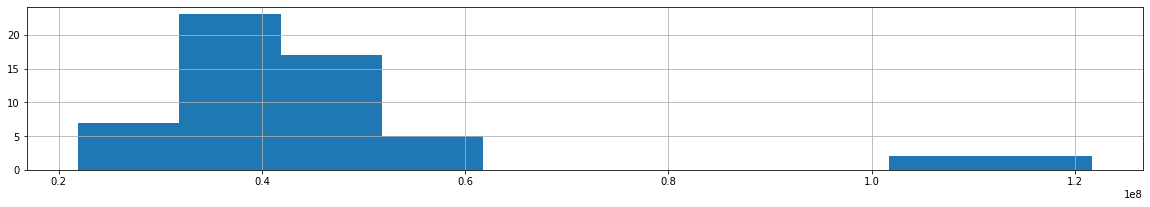

In [12]:
data.hist()

In [13]:
%matplotlib inline

La configuración del modelo ARIMA, depende del tipo de serie temporal que queramos predecir. Algunas de las características que hay que tener en cuenta són la autocorrelación i la autocorrelación parcial de los datos

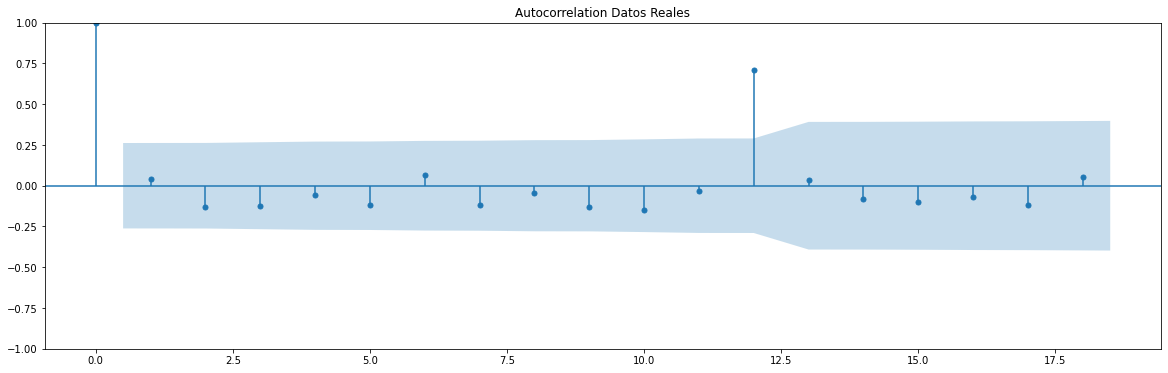

c:\Users\jgutierrez\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


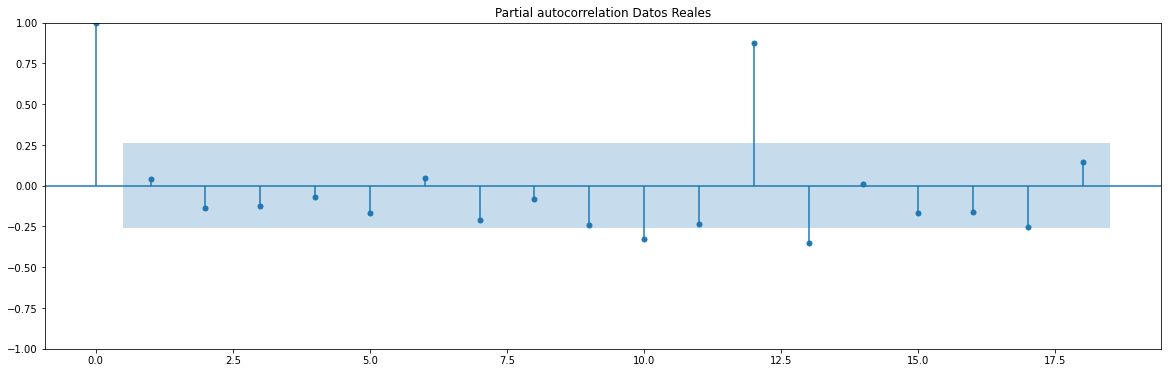

In [ ]:
#Correlation
acf = plot_acf(data)
plt.title('Autocorrelation Datos Reales')
plt.show()
pacf = plot_pacf(data)
plt.title('Partial autocorrelation Datos Reales')
plt.show()

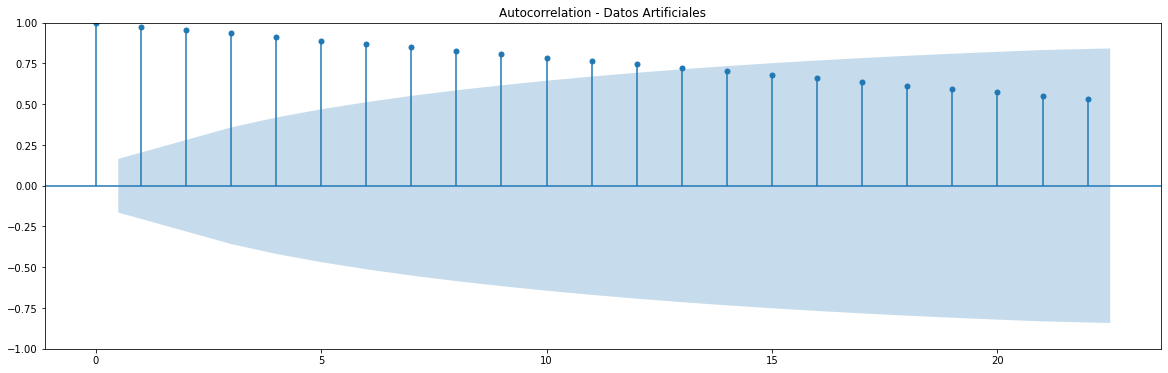

c:\Users\jgutierrez\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


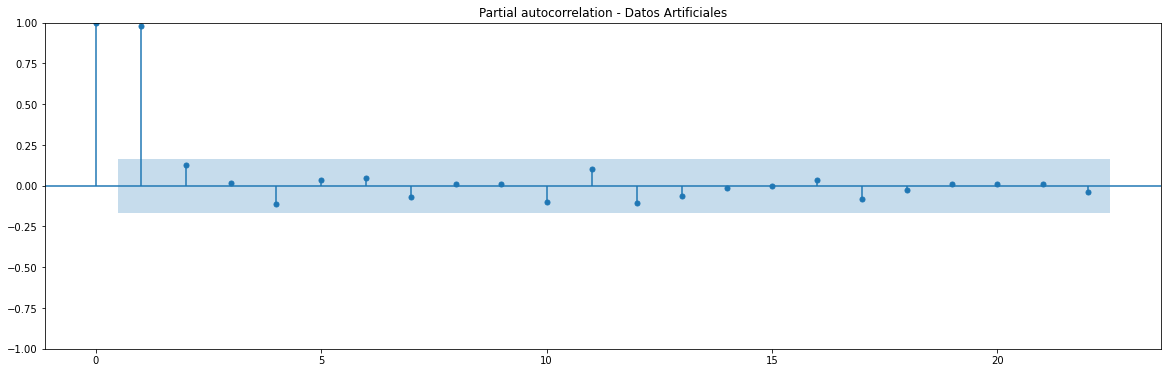

In [ ]:
#Correlation
acf = plot_acf(bdata)
plt.title('Autocorrelation - Datos Artificiales')
plt.show()
pacf = plot_pacf(bdata)
plt.title('Partial autocorrelation - Datos Artificiales')
plt.show()

Otra de las herramientas que tenemos a nuestra disposición para analizar el tipo de serie temporal que queremos predecir es el seasonal decompose, que descompone una série temporal en tres series: tendencia, temporada y residual. Analizar éstas gráficas nos puede dar información esencial para decidir qué modelos aplicar o con qué parámetros.

En éste caso aplicamos la función sólo a los datos reales. Mediante estas series podemos extraer información muy útil que nos ayudará a entender qué problemas tenemos que resolver y cómo podemos hacerlo. Por ejemplo si nuestros datos son estacionarios o si hay temporalidad.

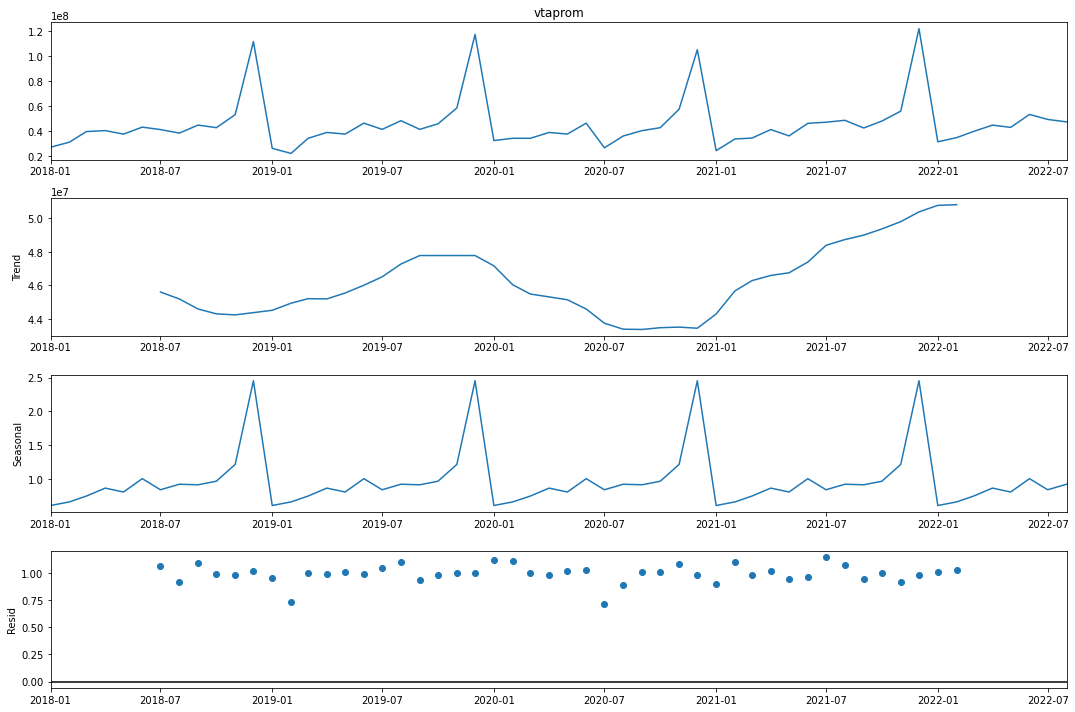

In [ ]:
#Descomposición Estacional
plt.rcParams["figure.figsize"] = (15,10)
data = data;
result = seasonal_decompose(data, model='multiplicative', period=12)
fig = result.plot()
plt.rcParams["figure.figsize"] = (20,6)

La función auto_arima realiza una búsqueda de la mejor configuración para el modelo ARIMA segun los datos de que disponemos. Eso no evita tener que pasarle una configuración inicial,que dependerá de la evaluaciónque hemos hecho con las herramientas anteriores.


In [ ]:
stepwise_model = auto_arima(mTrain,
                            start_p=5, d=0, start_q=2,
                            max_p=6, max_d=0, max_q=2,
                            start_P=0, D=0, start_Q=0,
                            max_P=2, max_D=2, max_Q=2,
                            max_order=2, m=5,
                            seasonal=True, stationary=False,
                            information_criterion='aic',
                            alpha=0.02,
                            trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True,
                            n_jobs=-1,
                            maxiter=10, verbose=0)
print(stepwise_model)

c:\Users\jgutierrez\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,0,0)(0,0,0)[5] intercept


In [ ]:
b_stepwise_model = auto_arima(bmTrain,
                            start_p=0, d=1, start_q=0,
                            max_p=4, max_d=2, max_q=0,
                            start_P=0, D=0, start_Q=0,
                            max_P=0, max_D=2, max_Q=0,
                            max_order=2, m=1,
                            seasonal=False, stationary=False,
                            information_criterion='aic',
                            alpha=0.02,
                            trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True,
                            n_jobs=-1,
                            maxiter=10)
print(stepwise_model)

c:\Users\jgutierrez\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,0,0)(0,0,0)[5] intercept


Entrenamiento de los modelos

In [ ]:
stepwise_model.fit(mTrain)
future_forecast = stepwise_model.predict(n_periods=PERIODS_TO_PREDICT)

b_stepwise_model.fit(bmTrain)
b_future_forecast = b_stepwise_model.predict(n_periods=bPERIODS_TO_PREDICT)

Representación de los resultados
Datos reales

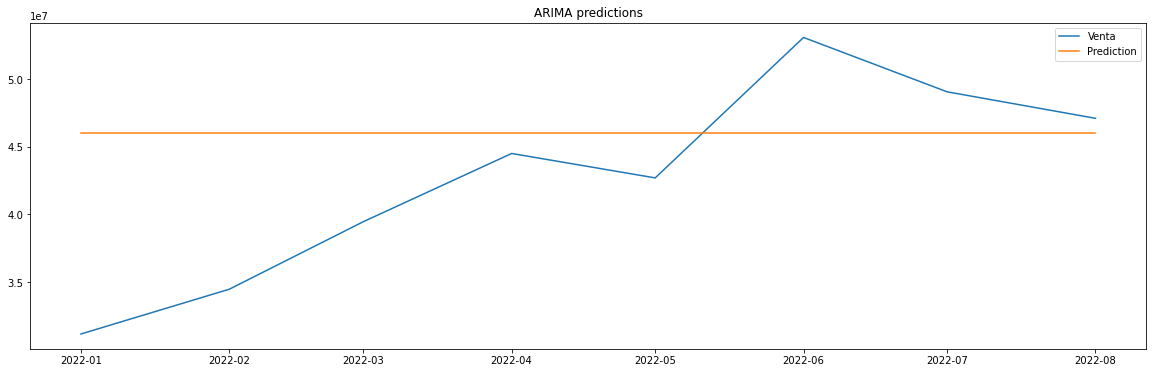

In [ ]:
future_forecast = pd.DataFrame(future_forecast, index = mTest.index,columns=['Prediction'])
df = pd.concat([mTest,future_forecast],axis=1)
plt.plot(df['vtaprom'], label='Venta')
plt.plot(df['Prediction'], label='Prediction')
plt.legend()
plt.title('ARIMA predictions')
plt.show()

Representación de los resultados
Datos artificiales

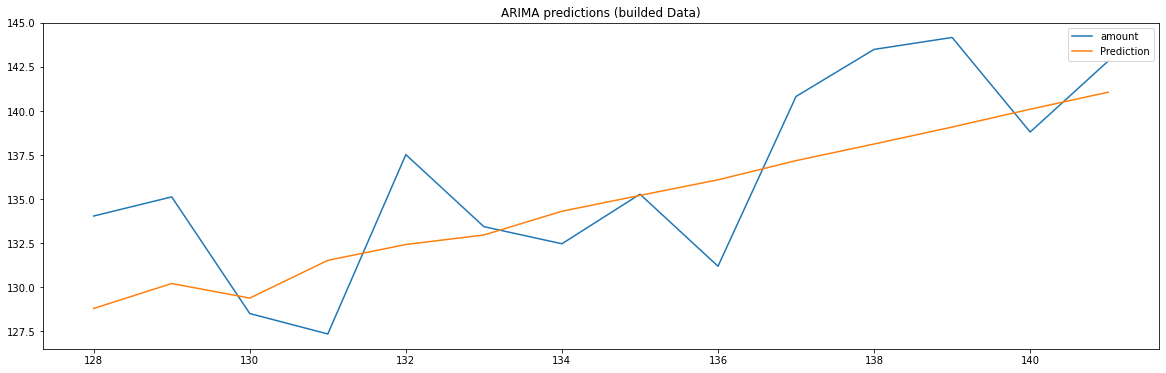

In [ ]:
b_future_forecast = pd.DataFrame(b_future_forecast, index = bmTest.index,columns=['Prediction'])
b_df = pd.concat([bmTest,b_future_forecast],axis=1)
plt.plot(bmTest, label='amount')
plt.plot(b_future_forecast, label='Prediction')
plt.legend()
plt.title('ARIMA predictions (builded Data)')
plt.show()

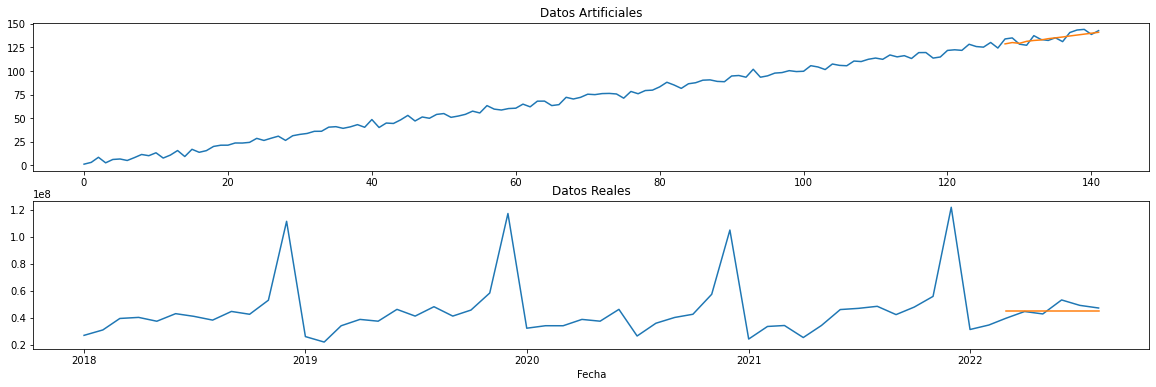

In [ ]:
df = pd.concat([data,future_forecast],axis=1)
bdf = pd.concat([bdata,b_future_forecast],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(bdf)
ax2.plot(df)
ax1.set_title('Datos Artificiales')
ax2.set_xlabel('Fecha')
ax2.set_title('Datos Reales')
plt.show()